In [1]:
import numpy as np
from qiskit import *
import math
%matplotlib inline

In [2]:
def Init_Circuit(psi_1,psi_2,B,peso_1,peso_2,af):
    # Build Circuit:
    bit_measure = ClassicalRegister(3, name='bit_measure')
    y = QuantumRegister(1, name='y')
    bias = QuantumRegister(1, name='bias')
    strach = QuantumRegister(1, name='strach')
    input1 = QuantumRegister(1, name='input1')
    input2 = QuantumRegister(1, name='input2')
    circuit  = QuantumCircuit(bias ,input1,input2, y, strach, bit_measure,name='Qperceptron')
    
    # Initialize:
    circuit.reset(y)
    circuit.reset(strach)    
    if(psi_1 == 1):
        circuit.initialize([0,1], [input1])
        
    elif(psi_1 == 0):
        circuit.reset(input1)
    
    if(psi_2 == 1):
        circuit.initialize([0,1], [input2])
    elif(psi_2 == 0):
        circuit.reset(input2)
        
    if(B == 1):
        circuit.initialize([0,1], [bias])
    elif(B == 0):
        circuit.reset(bias)
        
    if(af == 1):
        active_function = 180
    else:
        active_function = 0
        
    circuit.h(input1)
    circuit.h(input2)
    circuit.rz(math.radians(peso_1), input1)
    circuit.rz(math.radians(peso_2), input2)
    circuit.h(input1)
    circuit.h(input2)
    circuit.barrier()
        
    ## Strach-Y-part1-Circuit:
    circuit.ccx(input1,input2,y)
    circuit.ccx(bias,input1,input2)

    # Toffoli-triple (have to use the strach):
    circuit.ccx(bias,input1,strach)
    circuit.ccx(input2,strach,y)
    circuit.ccx(input1,bias,strach)

    circuit.barrier()
    
    
    ## Bias-Circuit:
    circuit.x(input1)

    # Toffoli-triple (have to use the strach):
    circuit.ccx(bias,input1,strach)
    circuit.ccx(input2,strach,y)
    circuit.ccx(input1,bias,strach)

    circuit.x(input1)
    circuit.x(input2)

    circuit.barrier()
    
    ### Active-Function:
    circuit.h(y)
    circuit.rz(math.radians(active_function), y)
    circuit.h(y)

    circuit.barrier()

    # Toffoli-triple (have to use the strach):
    circuit.ccx(bias,input1,strach)
    circuit.ccx(input2,strach,y)
    circuit.ccx(input1,bias,strach)

    circuit.barrier()
    ########## Measurement ##########
    
    circuit.measure(input1,bit_measure[0])
    circuit.measure(input2,bit_measure[1])
    circuit.measure(y,bit_measure[2])


    # Calculate the outputs
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()

    counts = result.get_counts(circuit)
    # Measure Result
    result_dict = counts
    # Outputstate_result
    outputstate = result.get_statevector(circuit, decimals=3)

    for key in counts.keys():
        result = str(key)
    outputs_list = [int(i) for i in str(result)]

    result_input1 = outputs_list[0]
    result_input2 = outputs_list[1]
    result_y = outputs_list[2]
    
    return (circuit,result_input1,result_input2,result_y,counts,outputstate)
    
    
            


In [3]:
# variables:

psi1 = 0
psi2 = 0
Bias = 0

teta1 = 0
teta2 = 0
Active_F = 0


circuit,result_input1,result_input2,result_y,counts,outputstate = Init_Circuit(psi1,psi2,Bias,teta1,teta2,Active_F)


print(("Y outuput = {}, Inputs_Outputs = {},{}").format(result_input1,result_input2,result_y) )

Y outuput = 0, Inputs_Outputs = 1,0


## Teste-QuantumPerceptron:
* 1°) Initialize random (0° or 180°) weights , dW = 0 , F = 0
* 2°) Calculate the error for witch Input
* 3°) e = |yd - y|
* 4°) dW = dW + 180°
* 5°) After finish all trials, do: 
                                   Sum dW >= 360 -> F = int(not(F))
                                   Sum dW < 360 and >= 0 -> F = F
                                   Sum dW <= 0 -> B = int(not(B))
                                   W = W + dW

In [4]:
# Init:
# Port-AND:


def Trials(psi1,psi2,Bias,teta1,teta2,Active_F,output,deltaW):
    erro_count = 0
    for i in range(4):
        circuit,result_y,result_input2,result_input1,counts,outputstate = Init_Circuit(psi1[i],psi2[i],Bias,teta1,teta2,Active_F)
        print(("Y outuput = {}, Y desiered = {}, Inputs = {},{}").format(result_y,output[i],psi1[i],psi2[i]) )
        erro = result_y - output[i]
        erro_count += abs(erro)
        deltaW[0] = deltaW[0] + abs(erro)*psi1[i]*180
        deltaW[1] = deltaW[1] + abs(erro)*psi2[i]*180
    return (deltaW,erro_count,counts)
        
        

if __name__ == '__main__':
    psi1 = [0,0,1,1]
    psi2 = [0,1,0,1]
    
    # Gate choose
    output = [1,0,0,1]
    # Random variables:
    Bias = 0
    teta1 = 180
    teta2 = 180
    Active_F = 0
    deltaW = [0,0]
    
    print( (" Initialize Teta1 = {}, Teta2 = {}").format(teta1,teta2) )
    for i in range(10):
        print( ("Epoch = {} \n").format(i) )
        (W,erro,counts) = Trials(psi1,psi2,Bias,teta1,teta2,Active_F,output,deltaW)
        print("\n")
        print( ("Delta W1 = {}, Delta W2 = {} \n").format(W[0],W[1]) )
        print( ("Sum Delta W = {} , Complete Delta W ={}, erro_total = {} \n").format(sum(W),360*len(W),erro) )

        # Refresh
        if(erro == 0):
            print("Sucess!")
            break
        else:      
            if(sum(W) >= 360*len(W)):
                Active_F = int(not(Active_F))  
            elif(sum(W) <= 0):
                Bias = int(not(Bias))

        teta1 = teta1 + W[0]%360
        teta2 = teta2 + W[1]%360
        deltaW = [0,0]
        
    print("\n")
    print( ("Answer: Teta1 = {} , Teta2 = {}, Active = {}, Bias = {}").format(teta1,teta2,Active_F,Bias) )
        



 Initialize Teta1 = 180, Teta2 = 180
Epoch = 0 

Y outuput = 1, Y desiered = 1, Inputs = 0,0
Y outuput = 0, Y desiered = 0, Inputs = 0,1
Y outuput = 0, Y desiered = 0, Inputs = 1,0
Y outuput = 0, Y desiered = 1, Inputs = 1,1


Delta W1 = 180, Delta W2 = 180 

Sum Delta W = 360 , Complete Delta W =720, erro_total = 1 

Epoch = 1 

Y outuput = 0, Y desiered = 1, Inputs = 0,0
Y outuput = 0, Y desiered = 0, Inputs = 0,1
Y outuput = 0, Y desiered = 0, Inputs = 1,0
Y outuput = 1, Y desiered = 1, Inputs = 1,1


Delta W1 = 0, Delta W2 = 0 

Sum Delta W = 0 , Complete Delta W =720, erro_total = 1 

Epoch = 2 

Y outuput = 0, Y desiered = 1, Inputs = 0,0
Y outuput = 1, Y desiered = 0, Inputs = 0,1
Y outuput = 1, Y desiered = 0, Inputs = 1,0
Y outuput = 0, Y desiered = 1, Inputs = 1,1


Delta W1 = 360, Delta W2 = 360 

Sum Delta W = 720 , Complete Delta W =720, erro_total = 4 

Epoch = 3 

Y outuput = 1, Y desiered = 1, Inputs = 0,0
Y outuput = 0, Y desiered = 0, Inputs = 0,1
Y outuput = 0, Y des

# Ploting Graphics

In [4]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

##                     1) Result for AND Gate

In [5]:
# variables:

# Possiple Variables = [00,01,10,11]
psi1 = [0,0,1,1]
psi2 = [0,1,0,1]

Bias = 0

teta1 = 0
teta2 = 0
Active_F = 0

counts_total = {}
outputstate_vector = []

for i in range(4):
    circuit,result_y,result_input2,result_input1,counts,outputstate= Init_Circuit(psi1[i],psi2[i],Bias,teta1,teta2,Active_F)

    inputs = str(psi1[i]) + str(psi2[i])
    output = str(result_y)
    counts_total[str(inputs)] = str(result_y)
    outputstate_vector.append(outputstate_vector)


print(counts_total)
print(len(outputstate_vector))

{'00': '0', '01': '0', '10': '0', '11': '1'}
4


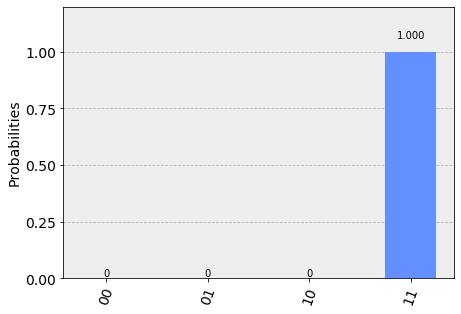

In [6]:
plot_histogram(counts_total)

# Making more graphics

In [36]:
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere

psi1 = 1
psi2 = 1
Bias = 0
# Angles
teta1 = 0
teta2 = 0
Active_F = 0

circuit,result_y,result_input2,result_input1,counts,outputstate= Init_Circuit(psi1,psi2,Bias,teta1,teta2,Active_F)
print(counts)
print(outputstate)

{'101': 1}
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 1.-0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j]


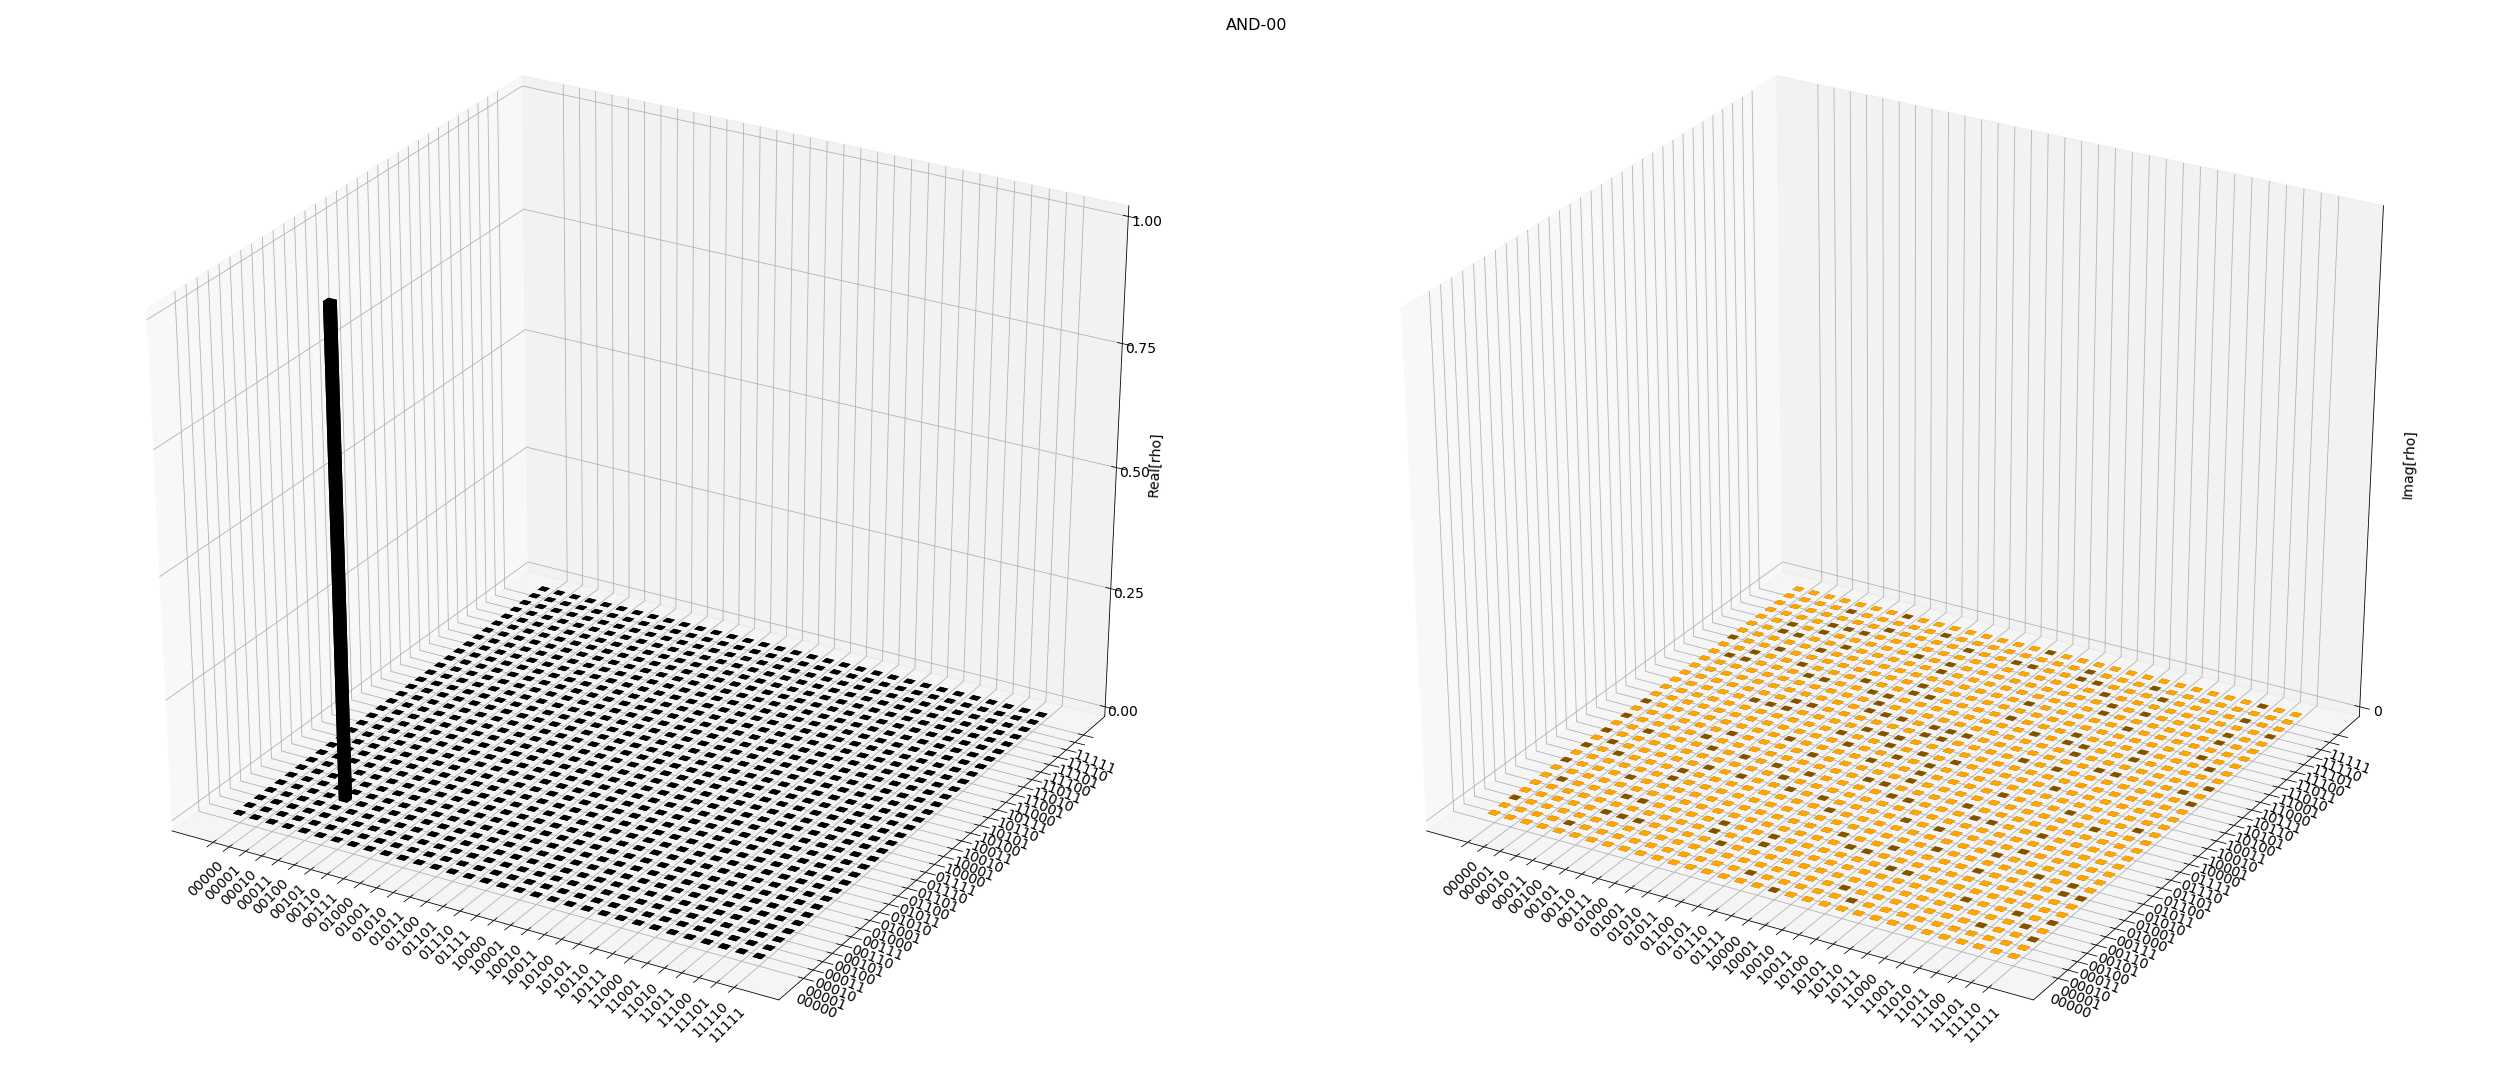

In [14]:
plot_state_city(outputstate,title="AND-00", color=['black', 'orange'],figsize = (35,15))

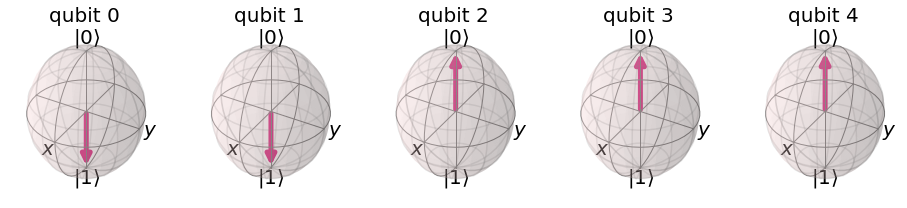

In [26]:
plot_bloch_multivector(outputstate)

# IBM account

In [29]:
from qiskit import IBMQ

IBMQ.save_account('1fa95665db3109aec38dd85ad6b17fd40d19b5030114ecfa63d724698d0b4b694db139988885269d55e9595a2f51966e2cb8130bf6b3fcf5569bb5eb0497bf5f')

In [30]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [31]:
IBMQ.providers()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>]

In [32]:
provider = IBMQ.get_provider(group='open')

In [33]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [34]:
backend = provider.get_backend('ibmq_16_melbourne')

In [62]:
def IBM_Circuit(psi_1,psi_2,B,peso_1,peso_2,af,backend):
    # Build Circuit:
    bit_measure = ClassicalRegister(3, name='bit_measure')
    y = QuantumRegister(1, name='y')
    bias = QuantumRegister(1, name='bias')
    strach = QuantumRegister(1, name='strach')
    input1 = QuantumRegister(1, name='input1')
    input2 = QuantumRegister(1, name='input2')
    circuit  = QuantumCircuit(bias ,input1,input2, y, strach, bit_measure,name='Qperceptron')
    
    # Initialize:
    circuit.reset(y)
    circuit.reset(strach)    
    if(psi_1 == 1):
        circuit.initialize([0,1], [input1])
        
    elif(psi_1 == 0):
        circuit.reset(input1)
    
    if(psi_2 == 1):
        circuit.initialize([0,1], [input2])
    elif(psi_2 == 0):
        circuit.reset(input2)
        
    if(B == 1):
        circuit.initialize([0,1], [bias])
    elif(B == 0):
        circuit.reset(bias)
        
    if(af == 1):
        active_function = 180
    else:
        active_function = 0
        
    circuit.h(input1)
    circuit.h(input2)
    circuit.rz(math.radians(peso_1), input1)
    circuit.rz(math.radians(peso_2), input2)
    circuit.h(input1)
    circuit.h(input2)
    circuit.barrier()
        
    ## Strach-Y-part1-Circuit:
    circuit.ccx(input1,input2,y)
    circuit.ccx(bias,input1,input2)

    # Toffoli-triple (have to use the strach):
    circuit.ccx(bias,input1,strach)
    circuit.ccx(input2,strach,y)
    circuit.ccx(input1,bias,strach)

    circuit.barrier()
    
    
    ## Bias-Circuit:
    circuit.x(input1)

    # Toffoli-triple (have to use the strach):
    circuit.ccx(bias,input1,strach)
    circuit.ccx(input2,strach,y)
    circuit.ccx(input1,bias,strach)

    circuit.x(input1)
    circuit.x(input2)

    circuit.barrier()
    
    ### Active-Function:
    circuit.h(y)
    circuit.rz(math.radians(active_function), y)
    circuit.h(y)

    circuit.barrier()

    # Toffoli-triple (have to use the strach):
    circuit.ccx(bias,input1,strach)
    circuit.ccx(input2,strach,y)
    circuit.ccx(input1,bias,strach)

    circuit.barrier()
    ########## Measurement ##########
    
    circuit.measure(input1,bit_measure[0])
    circuit.measure(input2,bit_measure[1])
    circuit.measure(y,bit_measure[2])


    # Calculate the outputs
    backend = backend
    
    mapped_circuit = transpile(circuit, backend=backend)
    qobj = assemble(mapped_circuit, backend=backend, shots=8192)
    job = backend.run(qobj)

    #job_exp = execute(circuit, backend)
    job_monitor(job)
    result_exp = job.result()
    

    counts = result_exp.get_counts(circuit)
    # Measure Result
    result_dict = counts
    # Outputstate_result
    #outputstate = result_exp.get_statevector(circuit, decimals=3)

    for key in counts.keys():
        result = str(key)
    outputs_list = [int(i) for i in str(result)]

    result_input1 = outputs_list[0]
    result_input2 = outputs_list[1]
    result_y = outputs_list[2]
    
    return (circuit,result_input1,result_input2,result_y,counts)
    

In [63]:
psi1 = 1
psi2 = 0
Bias = 1
# Angles
teta1 = 0
teta2 = 0
Active_F = 0

circuit,result_y,result_input2,result_input1,counts,outputstate= Init_Circuit(psi1,psi2,Bias,teta1,teta2,Active_F)

backend = provider.get_backend('ibmqx2')
circuit,result_y,result_input2,result_input1,counts_exp = IBM_Circuit(psi1,psi2,Bias,teta1,teta2,Active_F,backend)
print(counts)
print(counts_exp)


Job Status: job has successfully run
{'101': 1}
{'000': 813, '010': 840, '011': 1357, '001': 1201, '111': 1638, '110': 1020, '100': 564, '101': 759}


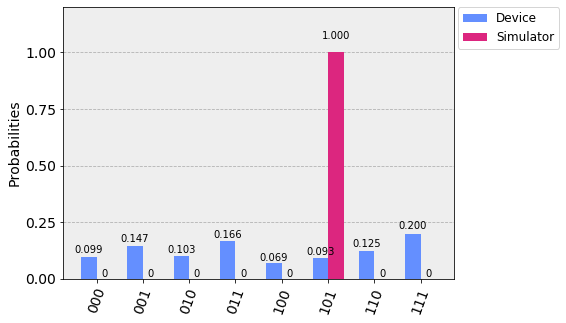

In [64]:
plot_histogram([counts_exp,counts], legend=['Device', 'Simulator'])